# fraud detection for Credit Card dataset
### by maryam babaei

### import libraries and File into Panda DataFrame

In [2]:
import pandas as pd
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc

In [3]:
data = pd.read_csv('creditcard.csv')

### show data

In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
colNames = data.columns.values
colNames

array(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
       'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27',
       'V28', 'Amount', 'Class'], dtype=object)

In [6]:
dfFraud = data[data.Class==1]
dfNorm = data[data.Class==0]
ratio = float(len(dfFraud))/len(dfNorm)
print(ratio)

0.0017304750013189597


In [7]:
y_target = data.Class
X_data = data.drop(['Class'], axis=1)

### Analysis some columns of Data

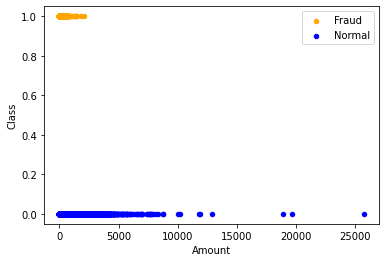

This feature looks important based on their distribution with respect to class.


In [8]:
ax = dfFraud.plot.scatter(x='Amount', y='Class', color='Orange', label='Fraud')
dfNorm.plot.scatter(x='Amount', y='Class', color='Blue', label='Normal', ax=ax)
plt.show()
print("This feature looks important based on their distribution with respect to class.")

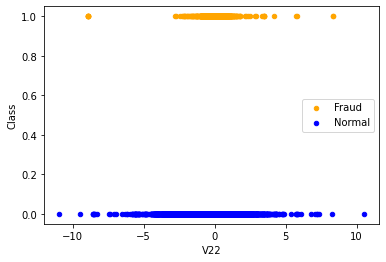

This feature may not be very important because of the similar distribution.


In [9]:
ax = dfFraud.plot.scatter(x='V22', y='Class', color='Orange', label='Fraud')
dfNorm.plot.scatter(x='V22', y='Class', color='Blue', label='Normal', ax=ax)
plt.show()
print("This feature may not be very important because of the similar distribution.")

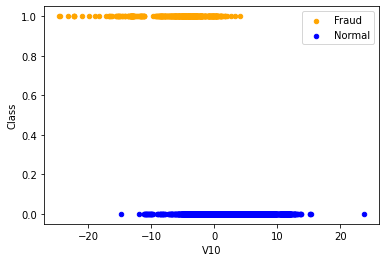

In [10]:
ax = dfFraud.plot.scatter(x='V10', y='Class', color='Orange', label='Fraud')
dfNorm.plot.scatter(x='V10', y='Class', color='Blue', label='Normal', ax=ax)
plt.show()

### use Linear Discriminant Analysis for feature Selection
### Plot shows number of features VS cross-validation scores

Optimal number of features is 11


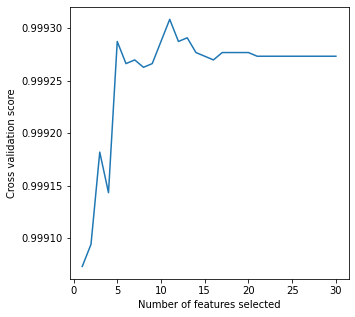

In [11]:
from sklearn import discriminant_analysis
from sklearn.feature_selection import RFECV
lda = discriminant_analysis.LinearDiscriminantAnalysis()
rfecv = RFECV(estimator=lda, step=1, cv=StratifiedKFold(3),scoring='accuracy')
rfecv.fit(X_data, y_target)

print("Optimal number of features is %d" % rfecv.n_features_)

plt.figure(figsize=(5,5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [12]:
print(X_data.columns.values[rfecv.support_])

['V3' 'V4' 'V7' 'V9' 'V10' 'V11' 'V12' 'V14' 'V16' 'V17' 'V18']


### shuffle and split data in train and test dataset

In [13]:
from sklearn.utils import shuffle
dfNorm = shuffle(dfNorm)
dfFraud = shuffle(dfFraud)

# Set X_train equal to 80% of the fraudulent transactions.
X_train = dfFraud.sample(frac=0.8)

# Add 80% of the normal transactions to X_train.
X_train = pd.concat([X_train, dfNorm.sample(frac = 0.8)], axis = 0)

# X_test contains all the transaction not in X_train(20%).
X_test = data.loc[~data.index.isin(X_train.index)]
# set y as class of data
y_train = X_train['Class']
y_test = X_test['Class']
X_train = X_train.iloc[:][X_data.columns.values[rfecv.support_]]
X_test = X_test.iloc[:][X_data.columns.values[rfecv.support_]]

In [14]:
X_data.shape, X_train.shape, X_test.shape

((284807, 30), (227846, 11), (56961, 11))

### Resampling using Imbalanced Learn cluster centroids

In [15]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(random_state=0)
X_resampled, y_resampled = cc.fit_sample(X_train, y_train)

X_train_ = X_resampled
y_train_ = y_resampled
X_test_ = X_test
y_test_ = y_test

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [16]:
X_train.shape, X_train_.shape, y_train.shape, y_train_.shape

((227846, 11), (788, 11), (227846,), (788,))

## Build Models and Make Predictions
### Quadratic Discriminant Analysis (QDA)

In [17]:
QDA_model = discriminant_analysis.QuadraticDiscriminantAnalysis()
QDA_model.fit(X_train_, y_train_)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

In [18]:
class_names = ["Normal", "Fraud"]

In [19]:
## This function prints and plots the confusion matrix:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [20]:
# Compute confusion matrix
def plotConfusion(model, X, y):
    y_true, y_pred = y, model.predict(X)
    cnf_matrix = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plt.figure(figsize=(5,5))
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

In [21]:
y_pred = QDA_model.predict(X_test_)

In [22]:
accqda=round(QDA_model.score(X_test_, y_test_)*100)
print("accuracy:")
QDA_model.score(X_test_, y_test_)

accuracy:


0.9822159021084602

Normalized confusion matrix
[[0.98 0.02]
 [0.16 0.84]]


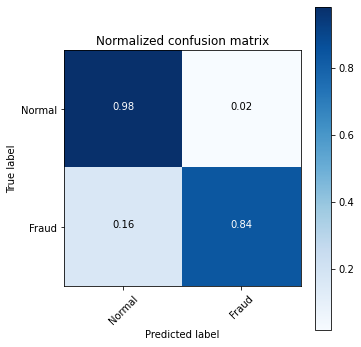

In [23]:
from sklearn.metrics import confusion_matrix
import itertools
from itertools import cycle
plotConfusion(QDA_model, X_test_, y_test_)

AUC: 0.950
AUROC curve:


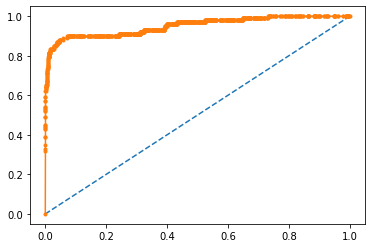

In [24]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score
from sklearn import metrics
probability = QDA_model.predict_proba(X_test_)
probs = probability[:, 1]
qda_false_positive_rate,qda_true_positive_rate,qda_threshold = roc_curve(y_test_,probs)
precision_QDA_model = round(precision_score(y_test_.astype(float), y_pred.astype(float), average='weighted')*100,2)
recall_QDA_model = round(recall_score(y_test_.astype(float), y_pred.astype(float), average='weighted')*100,2)
roc = roc_auc_score(y_test_.astype(float), probs)
print('AUC: %.3f' % roc)
fpr, tpr, thresholds = roc_curve(y_test_.astype(float), probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
print("AUROC curve:")
plt.show()

### Make Prediction

In [25]:
x_test = pd.read_csv("Book1.csv")
fraud = QDA_model.predict(x_test)
print(fraud)

[0 0]


### Logistic Regression (LR)

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
warnings.filterwarnings('ignore')
clf.fit(X_train_, y_train_)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [27]:
accclf=round(clf.score(X_test_, y_test_)*100,2)
print("accuracy:")
clf.score(X_test_, y_test_)

accuracy:


0.9937676655957585

Normalized confusion matrix
[[0.99 0.01]
 [0.17 0.83]]


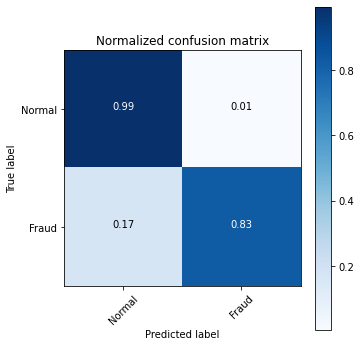

In [28]:
plotConfusion(clf, X_test_, y_test_)

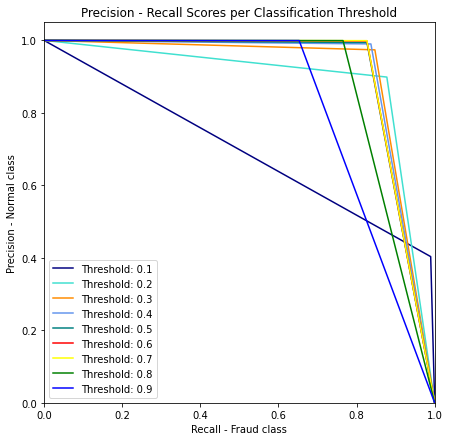

In [29]:
y_pred_test_proba = clf.predict_proba(X_test_)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black'])

prec, rec = [],[]
for i in thresholds:
    y_test_predictions_high_recall = y_pred_test_proba[:,1] > i
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test_,y_test_predictions_high_recall)
    np.set_printoptions(precision=2)
    
    p = float(cnf_matrix[0,0])/(cnf_matrix[0,1]+cnf_matrix[0,0])
    r = float(cnf_matrix[1,1])/(cnf_matrix[1,0]+cnf_matrix[1,1])
    rec.append(r)
    prec.append(p)

plt.figure(figsize=(7,7))

for i,color,r,p in zip(thresholds,colors,rec,prec):
    plt.plot([0, r, 1], [1, p, 0],color=color, label='Threshold: %s'%i)
    plt.ylabel('Precision - Normal class')
    plt.xlabel('Recall - Fraud class')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision - Recall Scores per Classification Threshold')
    plt.legend(loc="lower left")

In [30]:
y_pred = clf.predict(X_test_)

AUC: 0.969
AUROC curve:


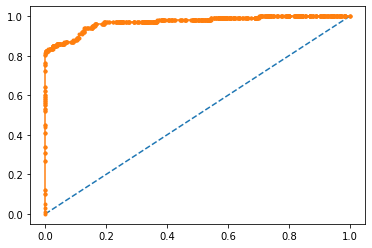

In [31]:
probability = clf.predict_proba(X_test_)
probs = probability[:, 1]
clf_false_positive_rate,clf_true_positive_rate,gb_threshold = roc_curve(y_test_,probs)
precision_clf = round(precision_score(y_test_.astype(float), y_pred.astype(float), average='weighted')*100,2)
recall_clf = round(recall_score(y_test_.astype(float), y_pred.astype(float), average='weighted')*100,2)
roc = roc_auc_score(y_test_.astype(float), probs)
print('AUC: %.3f' % roc)
fpr, tpr, thresholds = roc_curve(y_test_.astype(float), probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
print("AUROC curve:")
plt.show()

In [32]:
cross_val = cross_val_score(LogisticRegression(penalty='l2'), X_data, y_target, scoring='accuracy', cv=10)
print("Cross Validation value:")
cross_val_clf = round(cross_val.mean()*100, 2)
print(cross_val_clf)

Cross Validation value:
99.43


In [33]:
x_test = pd.read_csv("Book1.csv")
fraud = clf.predict(x_test)
print(fraud)

[0 0]


### Support Vector Machine

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import classification_report

clg = svm.SVC(kernel='linear', C=1)
tuned_parameters = [{'kernel': ['rbf','poly'], 'gamma': [1e-3,  1e-4], 'C': [1,10,100,1000]}]
scores = ['precision', 'recall']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    svm = GridSearchCV(SVC(probability=True), tuned_parameters, cv=5,scoring='%s_macro' % score)
    svm.fit(X_train_, y_train_)

    print("Best parameters set found on Training dataset:")
    print()
    print(svm.best_params_)

# Tuning hyper-parameters for precision

Best parameters set found on Training dataset:

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
# Tuning hyper-parameters for recall

Best parameters set found on Training dataset:

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}


In [35]:
import sklearn
accsvm=sklearn.metrics.accuracy_score(y_test_, svm.predict(X_test_))
print("accuracy:")
print(accsvm)
accsvm=round(accsvm*100,2)

accuracy:
0.9914678464212355


Normalized confusion matrix
[[0.99 0.01]
 [0.17 0.83]]


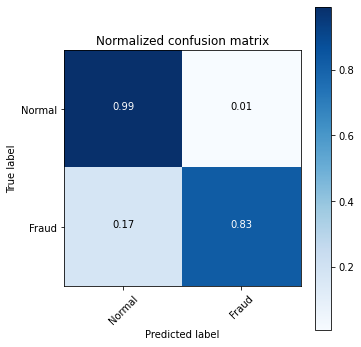

In [36]:
plotConfusion(svm, X_test_, y_test_)

In [37]:
y_pred = svm.predict(X_test_)

AUC: 0.955
AUROC curve:


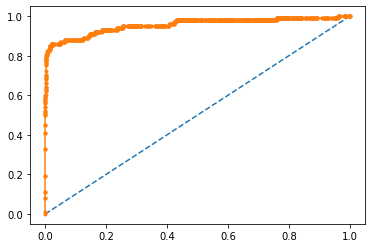

In [38]:
probability = svm.predict_proba(X_test_)
probs = probability[:, 1]
svm_false_positive_rate,svm_true_positive_rate,svm_threshold = roc_curve(y_test_,
                                                             probs)
precision_svm = round(precision_score(y_test_.astype(float), y_pred.astype(float), average='weighted')*100,2)
recall_svm = round(recall_score(y_test_.astype(float), y_pred.astype(float), average='weighted')*100,2)
roc = roc_auc_score(y_test_.astype(float), probs)
print('AUC: %.3f' % roc)
fpr, tpr, thresholds = roc_curve(y_test_.astype(float), probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
print("AUROC curve:")
plt.show()

In [39]:
x_test = pd.read_csv("Book1.csv")
fraud = svm.predict(x_test)
print(fraud)

[1 0]


### Comparison of QDA, LR and SVM

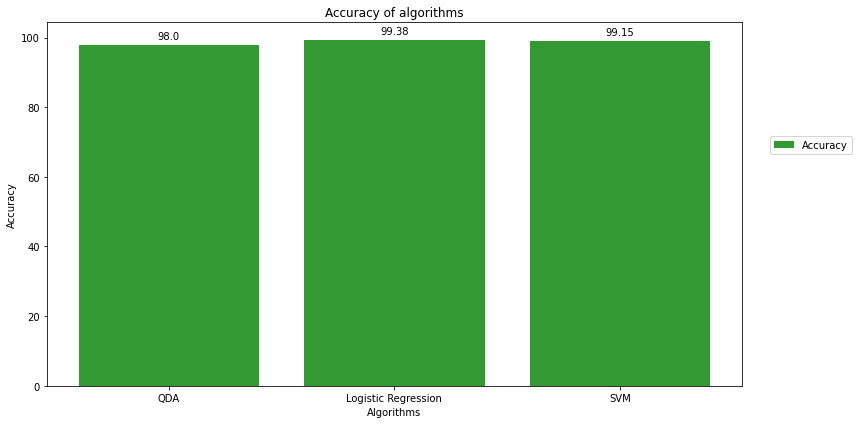

In [40]:
plt.rcParams['figure.figsize']=(12,6)
algorithm = ['QDA', 'Logistic Regression', 'SVM']
testaccuracy = [accqda, accclf, accsvm]
index = np.arange(len(algorithm))

fig, ax = plt.subplots()
bar_width = 0.8
opacity = 0.8

rects2 = plt.bar(index, testaccuracy, bar_width,alpha=opacity,color='g',label='Accuracy')
 
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')
plt.title('Accuracy of algorithms')
plt.xticks(index, algorithm)
plt.legend(loc=9, bbox_to_anchor=(1.1, 0.7), ncol=1) 
plt.tight_layout()
def autolabel(rects, xpos='center'):

    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom')

autolabel(rects2, "center")
plt.show()


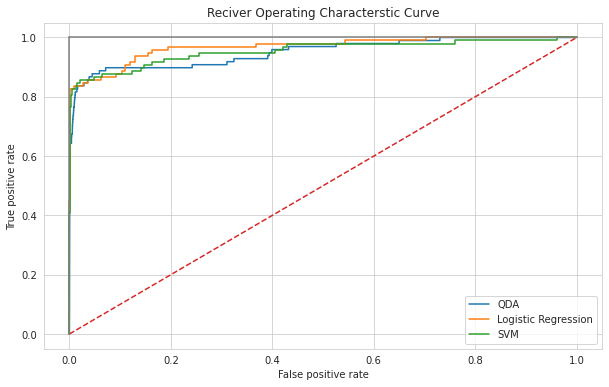

In [41]:
import seaborn as sns

sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(qda_false_positive_rate,qda_true_positive_rate,label='QDA')
plt.plot(clf_false_positive_rate,clf_true_positive_rate,label='Logistic Regression')
plt.plot(svm_false_positive_rate,svm_true_positive_rate,label='SVM')
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()